1. Load The Cleaned Data From Deliverable 2

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('citibike_2023_cleaned.csv')

In [3]:
df.head()

,rideable_type,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,month,day,start_hour,start_minute,end_hour,end_minute,trip_duration
0,classic_bike,Walton Ave & E 168 St,Icahn Stadium,40.836655,-73.918324,40.793460,-73.923890,member,6,25,6,44,7,2,17.933333
1,classic_bike,Grand Army Plaza & Central Park S,2 Ave & E 72 St,40.764004,-73.973974,40.768762,-73.958408,member,8,15,18,5,18,12,6.483333
2,classic_bike,Knickerbocker Ave & Thames St,Melrose St & Broadway,40.705446,-73.929975,40.697481,-73.935877,casual,7,5,15,0,15,6,6.100000
3,classic_bike,DeKalb Ave & Vanderbilt Ave,Pacific St & Classon Ave,40.689425,-73.968898,40.679194,-73.958790,member,3,5,11,29,11,36,7.566667
4,classic_bike,Liberty St & Broadway,West Thames St,40.708164,-74.010369,40.708347,-74.017134,member,10,17,15,2,15,6,4.283333


We will focus on station clustering

2.1 Data Prep for Station Clustering

In [9]:
station_frequency = df.groupby(['start_station_name', 'start_lat', 'start_lng']).size().reset_index(name='visit_count')


station_frequency.rename(columns={
    'start_station_name': 'station_name',
    'start_lat': 'latitude',
    'start_lng': 'longitude'
}, inplace=True)

scaler = MinMaxScaler()
station_frequency[['latitude', 'longitude']] = scaler.fit_transform(
    station_frequency[['latitude', 'longitude']]
)

2.2 Station Clustering - K-means

In [16]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
station_frequency['cluster'] = kmeans.fit_predict(station_frequency[['latitude', 'longitude', 'visit_count']])

C:\Users\Suzreal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


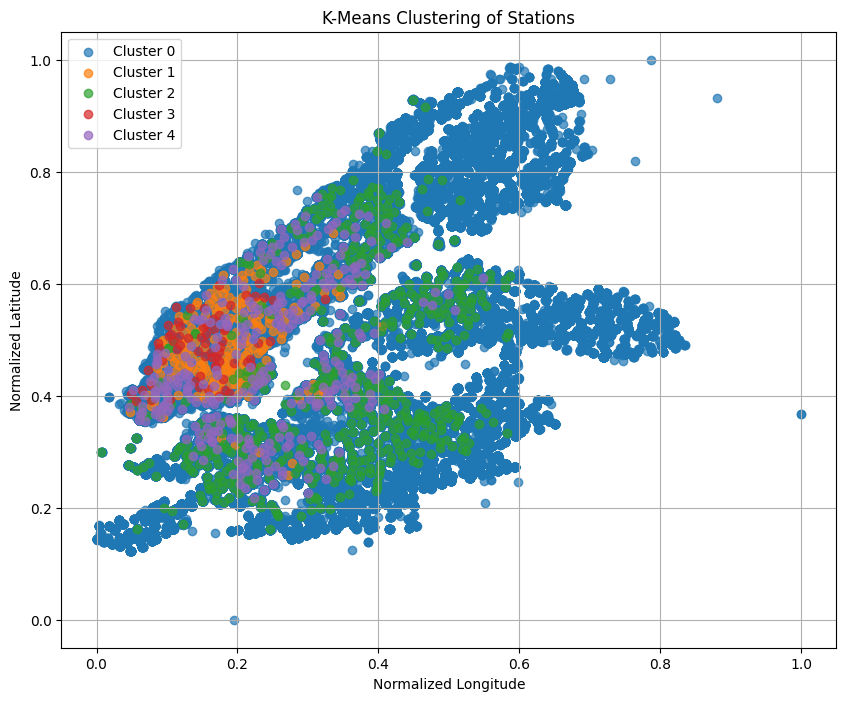

In [17]:
plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    cluster_data = station_frequency[station_frequency['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.title("K-Means Clustering of Stations")
plt.xlabel("Normalized Longitude")
plt.ylabel("Normalized Latitude")
plt.legend()
plt.grid(True)
plt.show()

If we are using 5 clusters, cluster 1 and 3, 2 and 4 have strong overlaping behavior. And cluster 0 overlaps with all of them. Let's try 3 clusters.

C:\Users\Suzreal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


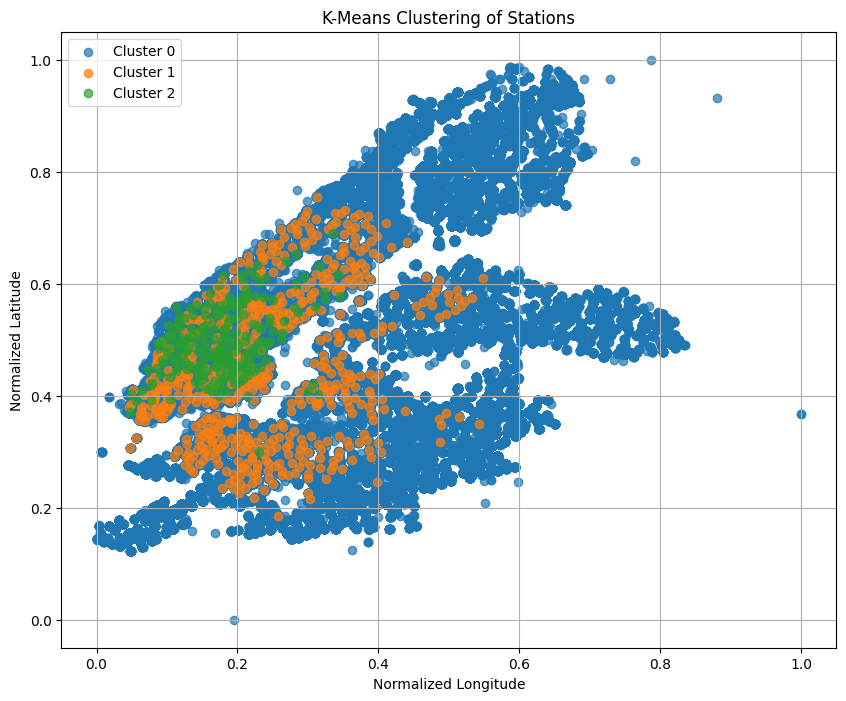

In [20]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
station_frequency['cluster'] = kmeans.fit_predict(station_frequency[['latitude', 'longitude', 'visit_count']])


plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    cluster_data = station_frequency[station_frequency['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.title("K-Means Clustering of Stations")
plt.xlabel("Normalized Longitude")
plt.ylabel("Normalized Latitude")
plt.legend()
plt.grid(True)
plt.show()

From what we can see here, the cluster 0 is still dominate, but cluster 1 and 2 shows some differences. Let's try to analysis the result.

3. Result Analysis

In [ ]:
cluster_result = station_frequency.groupby('cluster').agg(
    avg_visit_count=('visit_count', 'mean'),
    total_stations=('station_name', 'count'),
    avg_latitude=('latitude', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

#We track back the normalization process, since we use Min-max scaler, we track back to original range
original_lat_min = df['start_lat'].min()
original_lat_max = df['start_lat'].max()
original_lng_min = df['start_lng'].min()
original_lng_max = df['start_lng'].max()

cluster_result['latitude_original'] = cluster_result['avg_latitude'] * (original_lat_max - original_lat_min) + original_lat_min
cluster_result['longitude_original'] = cluster_result['avg_longitude'] * (original_lng_max - original_lng_min) + original_lng_min

We have the following average geographic data for each cluster:

Cluster 0: (40.745160321018155, -73.96758969140971)
Cluster 1: (40.72946044660379, -73.97317334264466)
Cluster 2: (40.742651102364555, -73.98880668887661)

And if we put these on a map using https://www.gps-coordinates.net/

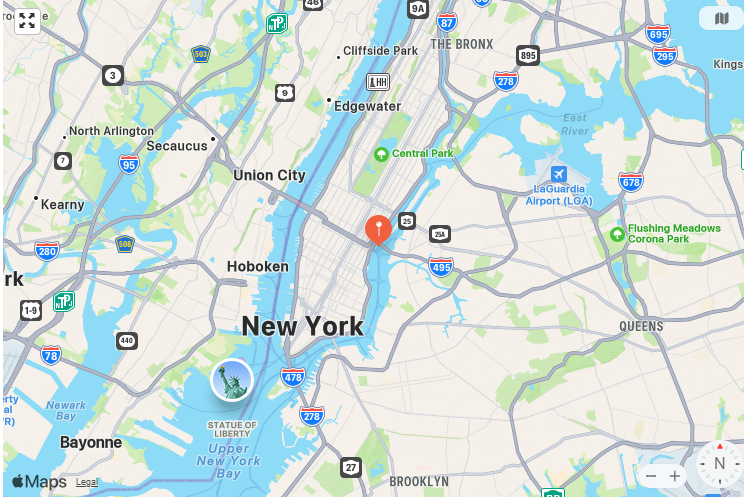

Cluster 0

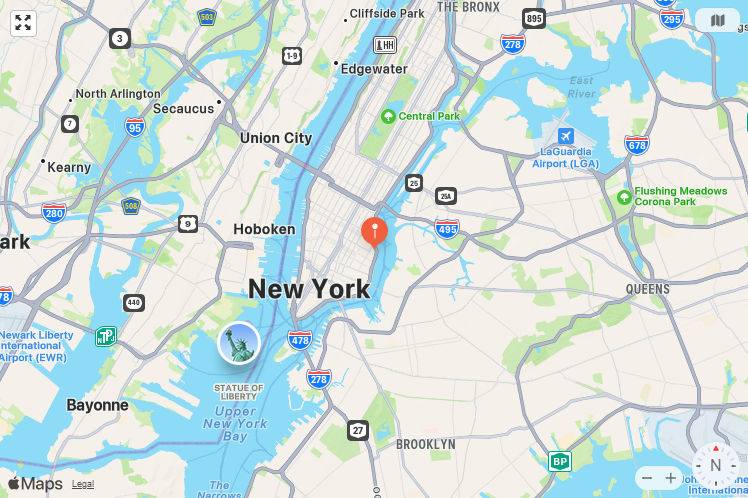

Cluster 1

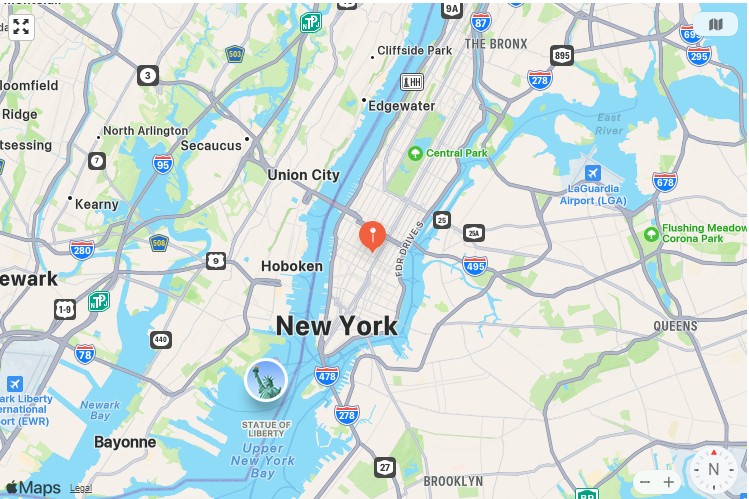


Cluster 2

As we can see above the distribution of 3 clusters, the major clusters is on mid-town east, where the most busy area of the city.